## Run the first 4 cells to import data and create training and testing set

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN,LSTM, Dense, Activation
from keras.utils import to_categorical
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# vals is a list whose elements are the data values to be plotted
# labels is a list of labels for each respective data set
def plot_hist(vals,labels='Null',title='Null',xlabel='epochs'):
    n = len(vals)
    for i in range(n): plt.plot(vals[i],label=labels[i])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

In [3]:
A01T = h5py.File('datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
data = np.transpose(data,(0,2,1))
data = data[:,:,:22]
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels-769, num_classes=4)
print(enc_labels)

#scaler = StandardScaler()
#data = scaler.fit_transform(data,enc_labels)

[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [4]:
bs, t, f = data.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

train_samples = 237
train_data = data[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data[shuffle[train_samples:],:,:]
test_labels =enc_labels[shuffle[train_samples:]]

# Everything from this point down is Testing

In [3]:
model = Sequential([
    LSTM(100, input_shape=(1000, 22)),
    Dense(32),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

In [4]:
model.layers

In [5]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=5,validation_split=0.25,batch_size=32)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

Train on 150 samples, validate on 50 samples
Epoch 1/5
150/150 [==============================] - 8s 55ms/step - loss: 1.3884 - acc: 0.2267 - val_loss: 1.3678 - val_acc: 0.3400
Epoch 2/5
150/150 [==============================] - 8s 53ms/step - loss: 1.3193 - acc: 0.4267 - val_loss: 1.3780 - val_acc: 0.3800
Epoch 3/5
150/150 [==============================] - 6s 39ms/step - loss: 1.2761 - acc: 0.5200 - val_loss: 1.3889 - val_acc: 0.3000
Epoch 4/5
150/150 [==============================] - 6s 41ms/step - loss: 1.2276 - acc: 0.5733 - val_loss: 1.3897 - val_acc: 0.3200
Epoch 5/5
87/87 [==============================] - 1s 10ms/step


In [6]:
test_score

[1.4324174310969211, 0.20689655103902707]

Modified VGG net to handle our input i.e. replace 2D with 1D, etc.(need to check dimensions and might need to transpose input to original shape)

Original VGGnet implementation can be found at hte address below

In [7]:
# VGGnet
# https://keras.io/getting-started/sequential-model-guide/#examples

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.optimizers import SGD

del model
model = Sequential()
#model.add(LSTM(100, input_shape=(1000, 22)))
model.add(Conv1D(32, 3, activation='relu',input_shape=(1000, 22)))             #Originally 32 each
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(64, 3, activation='relu'))                                    #Originally 64 each
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=5,validation_split=0.25,batch_size=32)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 150 samples, validate on 50 samples
Epoch 1/5
150/150 [==============================] - 3s 20ms/step - loss: 9.5186 - acc: 0.2933 - val_loss: 12.5721 - val_acc: 0.2200
Epoch 2/5
150/150 [==============================] - 2s 15ms/step - loss: 12.1423 - acc: 0.2467 - val_loss: 12.5721 - val_acc: 0.2200
Epoch 3/5
150/150 [==============================] - 2s 14ms/step - loss: 12.1423 - acc: 0.2467 - val_loss: 12.5721 - val_acc: 0.2200
Epoch 4/5
150/150 [==============================] - 2s 14ms/step - loss: 12.1423 - acc: 0.2467 - val_loss: 12.5721 - val_acc: 0.2200
Epoch 5/5
87/87 [==============================] - 0s 6ms/step


In [8]:
test_score

[11.856990112655465, 0.26436781420789918]

Simple RNN model

In [12]:
model = Sequential([
    SimpleRNN(64, input_shape=(t,f)),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=30,validation_split=0.25,batch_size=32)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

Train on 150 samples, validate on 50 samples
Epoch 1/30
150/150 [==============================] - 2s 13ms/step - loss: 1.6075 - acc: 0.2933 - val_loss: 1.5999 - val_acc: 0.2800
Epoch 2/30
150/150 [==============================] - 1s 9ms/step - loss: 1.4105 - acc: 0.3533 - val_loss: 1.5331 - val_acc: 0.3400
Epoch 3/30
150/150 [==============================] - 1s 9ms/step - loss: 1.3546 - acc: 0.4000 - val_loss: 1.4815 - val_acc: 0.3400
Epoch 4/30
150/150 [==============================] - 1s 9ms/step - loss: 1.2771 - acc: 0.4133 - val_loss: 1.4648 - val_acc: 0.2800
Epoch 5/30
150/150 [==============================] - 1s 9ms/step - loss: 1.1967 - acc: 0.4800 - val_loss: 1.4729 - val_acc: 0.2800
Epoch 6/30
150/150 [==============================] - 1s 10ms/step - loss: 1.1835 - acc: 0.5333 - val_loss: 1.4876 - val_acc: 0.2400
Epoch 7/30
150/150 [==============================] - 1s 9ms/step - loss: 1.1174 - acc: 0.5333 - val_loss: 1.5025 - val_acc: 0.2200
Epoch 8/30
150/150 [=========

In [11]:
test_score

[1.5717152137865966, 0.22988505712870894]

Here is the implementation of Figure 1b based on ChronoNet paper

In [20]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD


model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(1000, 22)))
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(Conv1D(32, 4, strides=2,activation='relu'))

#model.add(Flatten())

model.add(GRU(32,activation='relu',return_sequences=True))
model.add(GRU(32,activation='relu',return_sequences=True))
model.add(GRU(32,activation='relu'))


model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

#model.add()

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=10,validation_split=0.25,batch_size=32)
test_score = model.evaluate(test_data, test_labels, batch_size=32)
print(test_score)

Train on 150 samples, validate on 50 samples
Epoch 1/10
150/150 [==============================] - 4s 26ms/step - loss: 1.4257 - acc: 0.2000 - val_loss: 1.3854 - val_acc: 0.2800
Epoch 2/10
150/150 [==============================] - 2s 10ms/step - loss: 1.3816 - acc: 0.2800 - val_loss: 1.3918 - val_acc: 0.3200
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 1.3634 - acc: 0.3200 - val_loss: 1.3933 - val_acc: 0.3600
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 1.3452 - acc: 0.4067 - val_loss: 1.3961 - val_acc: 0.2800
Epoch 5/10
150/150 [==============================] - 2s 10ms/step - loss: 1.3278 - acc: 0.4200 - val_loss: 1.3875 - val_acc: 0.3600
Epoch 6/10
150/150 [==============================] - 2s 12ms/step - loss: 1.2998 - acc: 0.4867 - val_loss: 1.3958 - val_acc: 0.3400
Epoch 7/10
150/150 [==============================] - 2s 16ms/step - loss: 1.2640 - acc: 0.5000 - val_loss: 1.3845 - val_acc: 0.3400
Epoch 8/10
150/150 [====

Implementation of Figure 1b but adding regularization structures like that found in VGGnet

In [86]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(1000, 22)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

#model.add()

#model.compile(optimizer = 'rmsprop',
#             loss = 'categorical_crossentropy',
#             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(test_data, test_labels, batch_size=32)
print(test_score)

Train on 150 samples, validate on 50 samples
Epoch 1/15
150/150 [==============================] - 11s 75ms/step - loss: 1.3937 - acc: 0.2867 - val_loss: 1.4231 - val_acc: 0.1600
Epoch 2/15
150/150 [==============================] - 2s 10ms/step - loss: 1.3711 - acc: 0.3400 - val_loss: 1.4053 - val_acc: 0.2400
Epoch 3/15
150/150 [==============================] - 1s 9ms/step - loss: 1.3550 - acc: 0.3400 - val_loss: 1.4145 - val_acc: 0.2000
Epoch 4/15
150/150 [==============================] - 1s 10ms/step - loss: 1.3420 - acc: 0.4067 - val_loss: 1.4190 - val_acc: 0.1800
Epoch 5/15
150/150 [==============================] - 2s 11ms/step - loss: 1.3187 - acc: 0.3867 - val_loss: 1.4174 - val_acc: 0.2600
Epoch 6/15
150/150 [==============================] - 2s 11ms/step - loss: 1.3159 - acc: 0.3800 - val_loss: 1.4187 - val_acc: 0.2200
Epoch 7/15
150/150 [==============================] - 2s 10ms/step - loss: 1.2812 - acc: 0.4533 - val_loss: 1.4158 - val_acc: 0.2000
Epoch 8/15
150/150 [====

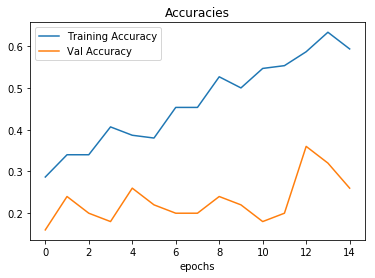

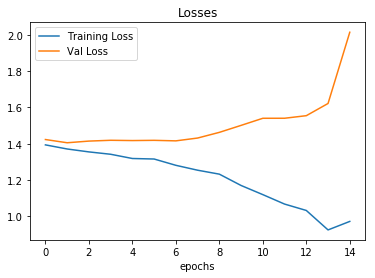

In [87]:
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


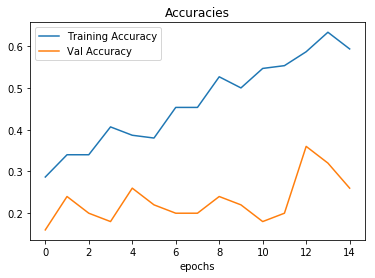

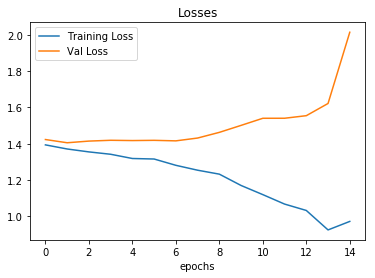

In [87]:
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


Replaced GRU with LSTM

In [93]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU,LSTM
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(1000, 22)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

#model.add()

#model.compile(optimizer = 'rmsprop',
#             loss = 'categorical_crossentropy',
#             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=40,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)
print(test_score)

87/87 [==============================] - 0s 3ms/step
[1.6541558517806831, 0.37931034105947647]


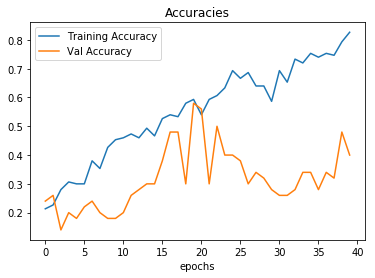

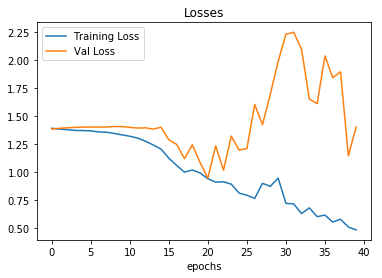

In [94]:
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## IC-RNN

In [29]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(1000,22))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)


x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh')(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=30,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=64)

50/50 [==============================] - 0s 4ms/step


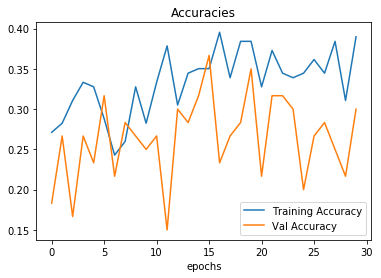

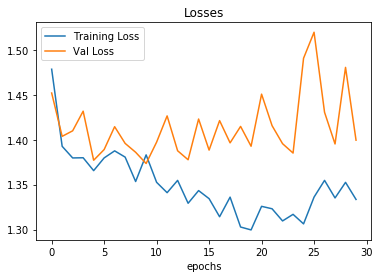

In [30]:
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## C-DRNN

In [32]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(1000,22))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=30,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

50/50 [==============================] - 1s 15ms/step


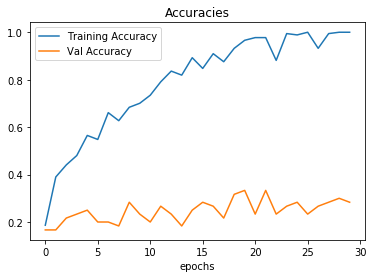

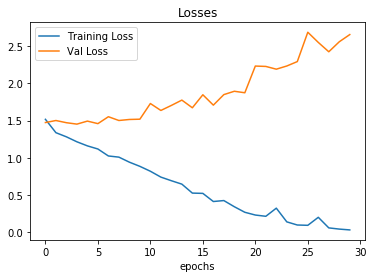

In [33]:
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


## ChronoNet

In [34]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(1000,22))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data,train_labels,epochs=30,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

50/50 [==============================] - 0s 8ms/step


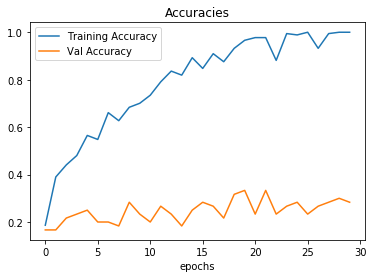

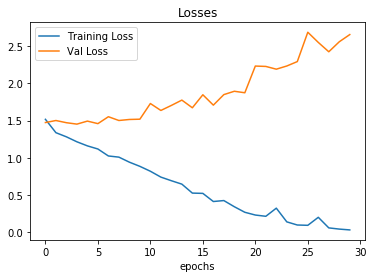

In [33]:
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')
